# Does California Carbon Investment Intensify Green Gentrification? 

PART 1: Data Cleaning and Processing

Haoyu Yue, Department of Urban Design and Planning, University of Washington

## Preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pyproj
import ipympl

In [3]:
#%matplotlib widget
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)

### Import Datasets

In [5]:
#spatial carbon investment data (location)
ca_line = gpd.read_file('data/capubdata/ca_line.gpkg')
ca_point = gpd.read_file('data/capubdata/ca_point.gpkg')
ca_polygon = gpd.read_file('data/capubdata/ca_polygon.gpkg')

In [ ]:
#carbon investment detailed data
cci = pd.read_csv('data/cci_2021_all.csv')

- Use Projected CRS, EPSG:3857, Name: WGS 84 / Pseudo-Mercator as main CRS. (From original investment dataset.)

In [7]:
#administration boundairs
sf_boundary = gpd.read_file('data/sf_boundaries.gpkg')
sf_boundary = sf_boundary.to_crs('EPSG:3857')

In [8]:
#import census block group
ca_bg = gpd.read_file('data/tl_2015_06_bg/tl_2015_06_bg.shp')
ca_bg = ca_bg.to_crs('EPSG:3857')

In [9]:
#population infomation from ACS 2019 5-year
ca_popu = pd.read_csv('data/ACSDT5Y_TotalPopulation_CA.csv')

### Define global varibales

In [58]:
SFMSA = ["San Francisco","Marin","Contra Costa","Alameda","San Mateo"] #the names of 5 counties
SFMSABOUNDARY = sf_boundary.total_bounds #the boundary of SF MSA
SFMSA_EXTENT = [-13694976,-13521897,4454076,4624901] 
YEARS = ['2015','2016','2017','2018','2019','2020',2015,2016,2017,2018,2019,2020] #six research years

### CCI Prep

In [13]:
cci['ProjectIDNumber'] = cci['ProjectIDNumber'].astype(str) 
cci['ReportingCycleName'] = cci['ReportingCycleName'].astype(str) #convert to string
cci_in_years = cci[cci['ReportingCycleName'].isin(YEARS)] #select in the specific years

### Repeated element
- In our spatial dataset, there are many projects occur more than one time so we need to come up with this issue. 

In [11]:
repeat_line_poly = ca_line.merge(ca_polygon,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()
repeat_point_poly = ca_point.merge(ca_polygon,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()
repeat_line_point = ca_line.merge(ca_point,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()

## Data Processing - Line Projects

### Get the shape for each line proj and Intersect the portion within research area/SF
- We need to disslove all line projects and calculate the amount of investment within SF MSA based on the proportion.

In [14]:
ca_line_dissolve = ca_line.dissolve(by='proj_id')

In [18]:
for i in ca_line_dissolve.index.unique():
    ca_line_dissolve.loc[i,'Shape_Length'] = ca_line_dissolve[ca_line_dissolve.index==i].geometry.length[0]   

In [19]:
sf_line = ca_line_dissolve.clip(sf_boundary) #clip the lines within SF

In [20]:
sf_line['Length_SF'] = np.nan #create a new column for length
sf_line['Percentage_in_SF'] = np.nan #create a new column for percentage of line within SF (what percentage of this project is within research area)

In [21]:
for i in sf_line.index.unique():
    sf_line.loc[i,'Length_SF'] = sf_line[sf_line.index==i].geometry.length[0]
    sf_line.loc[i,'Percentage_in_SF'] = sf_line.loc[i,'Length_SF']/sf_line.loc[i,'Shape_Length']

In [22]:
sf_line = sf_line.reset_index()

In [23]:
sf_line_npreduplicate = sf_line
#sf_line_npreduplicate = sf_line[~(sf_line['proj_id']=='0019000134')]#this proj is existing in all three kinds of data

### Merge with `cci` dataset (detailed proj info)

In [24]:
sf_line_npreduplicate['proj_id'] = sf_line_npreduplicate['proj_id'].astype(str)
sf_line_npreduplicate['proj_id'] = sf_line_npreduplicate['proj_id'].str.lstrip('0')#make sure all project ids are string as common columns

In [25]:
cci_line_in_SF = cci_in_years[cci_in_years['ProjectIDNumber'].isin(list(sf_line_npreduplicate.proj_id.unique()))]

In [26]:
sf_line_npreduplicate_geo = sf_line_npreduplicate[['proj_id', 'geometry','Shape_Length','Length_SF','Percentage_in_SF']] #only select geometry and proj_id

In [30]:
sf_line_invest_geo = sf_line_npreduplicate_geo.merge(cci_line_in_SF,left_on='proj_id',right_on='ProjectIDNumber',how='outer') #year * proj = a row

In [31]:
sf_line_invest_geo['FundingSF'] = sf_line_invest_geo['TotalProgramGGRFFunding'] * sf_line_invest_geo['Percentage_in_SF']

- The processing result dataset is `sf_line_invest_geo` and we need to allocate them in the future.

In [35]:
sf_line_invest_geo.columns

Index(['proj_id', 'geometry', 'Shape_Length', 'Length_SF', 'Percentage_in_SF',
       'ProjectIDNumber', 'ReportingCycleName', 'AgencyName', 'ProgramName',
       'ProgramDescription',
       ...
       'CommunityEngagement', 'CompostProducedTons', 'CompostProducedTonsYr',
       'NetDensityDUA', 'ApplicantsAssisted', 'InvasiveCover12Mon',
       'InvasiveCover36Mon', 'ProjectAcreage', 'IntermediaryAdminExpenses',
       'FundingSF'],
      dtype='object', length=121)

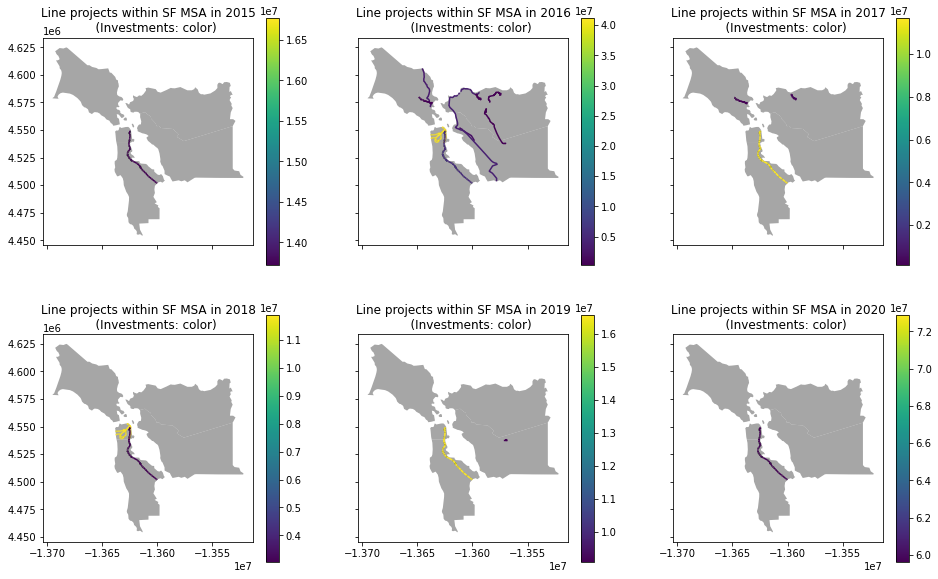

In [117]:
f,axs = plt.subplots(2,3,figsize=(16,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_line_invest_geo[sf_line_invest_geo.ReportingCycleName==y].plot(ax=ax,column='FundingSF',legend=True)
    ax.set_title(f'''Line projects within SF MSA in {y}
    (Investments: color)''')
plt.show()

In [ ]:
#sf_line_invest_geo.to_csv('data/01finished/sf_line.csv') 
sf_line_invest_geo.to_file('data/sf_project/sf_line.geojson', driver='GeoJSON')

## Data Processing - Polygon Projects


In [100]:
ca_polygon.proj_id = ca_polygon.proj_id.str.lstrip('0') #make sure all project ids are string as common columns

In [102]:
ca_polygon_dissolve = ca_polygon.dissolve(by='proj_id') 

In [103]:
for i in ca_polygon_dissolve.index.unique():
    ca_polygon_dissolve.loc[i,'Shape_Area'] = ca_polygon_dissolve[ca_polygon_dissolve.index==i].geometry.area.values[0]   

In [104]:
ca_polygon_dissolve = ca_polygon_dissolve.reset_index()

In [106]:
sf_polygon = ca_polygon_dissolve.clip(sf_boundary)

In [107]:
sf_polygon[sf_polygon['proj_id'].isin(['0020000276', '16-17-D03-034', '16-17-D03-035',
                        '16-17-D05-060', '0019000134', 'G14-AQIP-01','0020000276', '15-16-D8-110'])].proj_id.unique() #check the replicated projects

array(['G14-AQIP-01'], dtype=object)

In [108]:
sf_polygon_npreduplicate = sf_polygon[~(sf_polygon['proj_id']=='G14-AQIP-01')] #this proj is existing in all three kinds of data

In [109]:
sf_polygon_npreduplicate.head(3)

,proj_id,geometry,OBJECTID,reportingcyclename,agency,role_subprogram_id,subprogram_name,proj_name,proj_desc,census_tract,total_ggrf_funding,est_ghg_reductions,proj_benefits_desc,senate_district,assembly_district,COUNTY_NAME,BENEFITS_PRIORITY_YN,Shape_Length,Shape_Area
55,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",98555,2017,Department of Community Services and Development,90,Large Multi-Family Energy Efficiency and Renew...,Large Multi-Family Energy Efficiency and Renew...,Provides incentives to multi-family low-income...,06029004701,360954.0,2128,"Energy savings, employment opportunities, loca...",14,32,Kern,Yes,15228.246910,3.332901e+09
60,15S2-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",98193,2019,Department of Community Services and Development,90,Multi-Family Energy Efficiency and Renewables,Multi-Family Energy Efficiency and Renewables,Provides incentives to multi-family low-income...,06037239501,117533.0,483,"Energy savings, employment opportunities, loca...",30,59,Los Angeles,Yes,3887.257574,7.978858e+08
39,15-1-30,"MULTIPOLYGON (((-13619192.324 4569352.331, -13...",99308,2016,Department of Community Services and Development,88,Single-Family Energy Efficiency and Solar PV,Single Family/Small Multi-Family Energy Effici...,Provides single-family and small multi-family ...,06037575802,1187.0,4,"Energy savings, employment, training, improved...",33,70,Los Angeles,Yes,2903.499050,7.045420e+08


### Merge with `cci` data

In [110]:
sf_polygon_npreduplicate['proj_id'] = sf_polygon_npreduplicate['proj_id'].astype(str)
sf_polygon_npreduplicate['proj_id'] = sf_polygon_npreduplicate['proj_id'].str.lstrip('0')#make sure all project ids are string as common columns

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [111]:
cci_polygon_in_SF = cci_in_years[cci_in_years['ProjectIDNumber'].isin(list(sf_polygon_npreduplicate.proj_id.unique()))]

In [112]:
sf_polygon_npreduplicate_geo = sf_polygon_npreduplicate[['proj_id', 'geometry','Shape_Area']] #only select geometry and proj_id

In [113]:
sf_polygon_invest_geo = sf_polygon_npreduplicate_geo.merge(cci_polygon_in_SF,left_on='proj_id',right_on='ProjectIDNumber',how='outer')

In [114]:
sf_polygon_invest_geo.head(3)

,proj_id,geometry,Shape_Area,ProjectIDNumber,ReportingCycleName,AgencyName,ProgramName,ProgramDescription,SubProgramName,RecordType,ProjectName,ProjectType,ProjectDescription,CensusTract,Address,LatLong,TotalProjectCost,TotalProgramGGRFFunding,ProjectLifeYears,TotalProjectGHGReductions,AnnualProjectGHGReductions,ProjectCount,FiscalYearFundingProject,IsBenefitDisadvantagedCommunities,DisadvantagedCommunityCriteria,DisadvantagedCommunityNeed,DisadvantagedCommunityCensusTracts,TotalGGRFDisadvantagedCommunityFunding,DisadvantagedCommunityBenefitsDescription,FundingBenefitingDisadvantagedCommunities,EstimatedNumVehiclesInService,FundingWithinDisadvantageCommunities,OtherProjectBenefitsDescription,VMTReductions,NumberOfHousingUnits,NumberOfAffordableHousingUnits,EstimatedNumberOfTreesToBePlanted,ENERGY_Cost_Savings,EstimatedEnergySavedKWH,EstimatedEnergySavedTherms,EstimatedWaterSavedGallons,EstimatedEnergyGeneratedKWH,EstimatedFuelUseReductionGal,VouchersBenefitingDisadvantagedCommunities,NumberOfRebatesIssued,RebatesWithinDisadvantagedCommunities,DateOperational,ProjectCompletionDate,DateImported,FundingRecipient,AB1550Choice,BufferAmount,BufferCount,IsAB1550BufferRegion,CESVersion,DAC3Amount,DAC3Count,IsBenefitDAC3Communities,DateSelectedForAward,LowIncomeAmount,LowIncomeCount,LowIncomeHouseholdAmount,LowIncomeHouseholdCount,IsLowIncomeCommunities,PotentialBufferAmount,PotentialBufferCount,PotentialDAC3Amount,PotentialDAC3Count,PotentialLowIncomeAmount,PotentialLowIncomeCount,EstimatedAcresPreserved,EstimatedAcresRestored,EstimatedAcresTreated,EstimatedDivertedFromLandfillsTons,RenewableFuelGenerationTons,WoodBurningReductionCords,EstimatedRidershipIncreases,BlackCarbonReductionsTons,StateEW_DPM,StateEW_Nox,StateEW_PM25,StateEW_ROG,DieselPmReductionsLbs,NOxReductionsLbs,Pm25ReductionsLbs,RogReductionsTLbs,EstimatedTotalRecyclingTons,EstimatedWasteDigestedTons,ReclaimedFoodTons,NUMBER_OF_PLANS,POLLINATOR_ACREAGE,RESEARCH_GRANT,SCIENCE_ADVANCEMENT,SOIL_BENEFIT,TRAVEL_COST_SAVINGS,EST_ENERGY_GEN_SCF,EST_SOURCE_RED_TONS,FUEL_TREATMENT_NUM,EDUCATION_EVENT_NUM,ENERGY_AUDIT_BUILDINGS,EST_DIVERT_LANDFILLS_TONS,EST_FUEL_GEN_GAL,VoucherID,VoucherName,VoucherDescription,DirectJobsFte,IndirectJobsFte,InducedJobsFte,ClimateAdaptation,CommunityEngagement,CompostProducedTons,CompostProducedTonsYr,NetDensityDUA,ApplicantsAssisted,InvasiveCover12Mon,InvasiveCover36Mon,ProjectAcreage,IntermediaryAdminExpenses
0,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",3.332901e+09,15-3-31,2017,Department of Community Services and Development,Low-Income Weatherization Program,Reduces GHGs by installing energy efficiency a...,Large Multi-Family Energy Efficiency and Renew...,IMPLEMENT,NaN,NaN,Provides incentives to multi-family low-income...,6.001402e+09,NaN,NaN,108745.0,96773.0,25.0,379.0,15.0,22.0,NaN,True,4-1A,Common Need,6001401700,96773.0,NaN,0.0,0.0,96773.0,"Energy savings, employment opportunities, loca...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1203675.0,0.0,22.0,22.0,22.0,5/10/17,5/15/17,1/31/20 15:05,Association for Energy Affordability,NaN,0.0,0.0,False,2.0,0.0,0.0,False,NaN,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",3.332901e+09,15-3-31,2017,Department of Community Services and Development,Low-Income Weatherization Program,Reduces GHGs by installing energy efficiency a...,Large Multi-Family Energy Efficiency and Renew...,IMPLEMENT,NaN,NaN,Provides incentives to multi-family low-income...,6.001403e+09,NaN,NaN,364395.0,364394.0,5.0,1381.0,92.0,93.0,NaN,True,4-1A,Common Need,6001402800,364394.0,NaN,0.0,0.0,364394.0,"Energy savings, employment opportunities, loca...",0.0,0.0,0.0,0.0,0.0,1182917.0,189905.0,0.0,0.0,0.0,93.0,93.0,93.0,3/27/17,5/15/17,1/31/20 15:05,Association for Energy Affordab

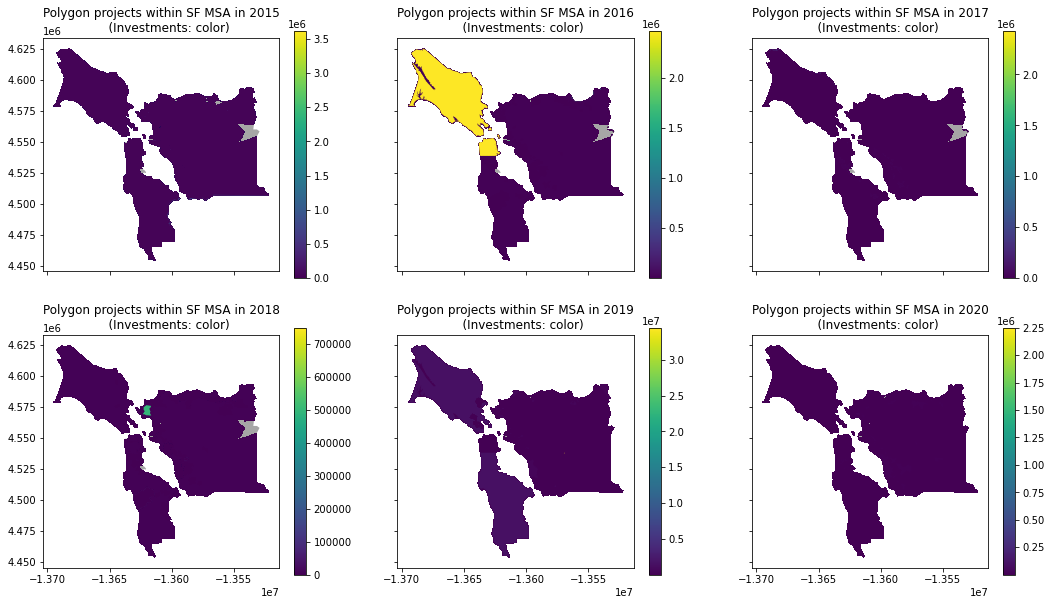

In [116]:
f,axs = plt.subplots(2,3,figsize=(18,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_polygon_invest_geo[sf_polygon_invest_geo.ReportingCycleName==y].plot(ax=ax,column='TotalProjectCost',legend=True,alpha=0.5)
    ax.set_title(f'''Polygon projects within SF MSA in {y}
    (Investments: color)''')
plt.show()

- So many overlaps of polygons! So the figure is meanfulless.

In [80]:
#output
#sf_polygon_invest_geo.to_csv('data/01finished/sf_polygon.csv') 
sf_polygon_invest_geo.to_file('data/sf_project/sf_polygon.geojson', driver='GeoJSON')

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [120]:
sf_polygon_invest_geo

,proj_id,geometry,Shape_Area,ProjectIDNumber,ReportingCycleName,AgencyName,ProgramName,ProgramDescription,SubProgramName,RecordType,ProjectName,ProjectType,ProjectDescription,CensusTract,Address,LatLong,TotalProjectCost,TotalProgramGGRFFunding,ProjectLifeYears,TotalProjectGHGReductions,AnnualProjectGHGReductions,ProjectCount,FiscalYearFundingProject,IsBenefitDisadvantagedCommunities,DisadvantagedCommunityCriteria,DisadvantagedCommunityNeed,DisadvantagedCommunityCensusTracts,TotalGGRFDisadvantagedCommunityFunding,DisadvantagedCommunityBenefitsDescription,FundingBenefitingDisadvantagedCommunities,EstimatedNumVehiclesInService,FundingWithinDisadvantageCommunities,OtherProjectBenefitsDescription,VMTReductions,NumberOfHousingUnits,NumberOfAffordableHousingUnits,EstimatedNumberOfTreesToBePlanted,ENERGY_Cost_Savings,EstimatedEnergySavedKWH,EstimatedEnergySavedTherms,EstimatedWaterSavedGallons,EstimatedEnergyGeneratedKWH,EstimatedFuelUseReductionGal,VouchersBenefitingDisadvantagedCommunities,NumberOfRebatesIssued,RebatesWithinDisadvantagedCommunities,DateOperational,ProjectCompletionDate,DateImported,FundingRecipient,AB1550Choice,BufferAmount,BufferCount,IsAB1550BufferRegion,CESVersion,DAC3Amount,DAC3Count,IsBenefitDAC3Communities,DateSelectedForAward,LowIncomeAmount,LowIncomeCount,LowIncomeHouseholdAmount,LowIncomeHouseholdCount,IsLowIncomeCommunities,PotentialBufferAmount,PotentialBufferCount,PotentialDAC3Amount,PotentialDAC3Count,PotentialLowIncomeAmount,PotentialLowIncomeCount,EstimatedAcresPreserved,EstimatedAcresRestored,EstimatedAcresTreated,EstimatedDivertedFromLandfillsTons,RenewableFuelGenerationTons,WoodBurningReductionCords,EstimatedRidershipIncreases,BlackCarbonReductionsTons,StateEW_DPM,StateEW_Nox,StateEW_PM25,StateEW_ROG,DieselPmReductionsLbs,NOxReductionsLbs,Pm25ReductionsLbs,RogReductionsTLbs,EstimatedTotalRecyclingTons,EstimatedWasteDigestedTons,ReclaimedFoodTons,NUMBER_OF_PLANS,POLLINATOR_ACREAGE,RESEARCH_GRANT,SCIENCE_ADVANCEMENT,SOIL_BENEFIT,TRAVEL_COST_SAVINGS,EST_ENERGY_GEN_SCF,EST_SOURCE_RED_TONS,FUEL_TREATMENT_NUM,EDUCATION_EVENT_NUM,ENERGY_AUDIT_BUILDINGS,EST_DIVERT_LANDFILLS_TONS,EST_FUEL_GEN_GAL,VoucherID,VoucherName,VoucherDescription,DirectJobsFte,IndirectJobsFte,InducedJobsFte,ClimateAdaptation,CommunityEngagement,CompostProducedTons,CompostProducedTonsYr,NetDensityDUA,ApplicantsAssisted,InvasiveCover12Mon,InvasiveCover36Mon,ProjectAcreage,IntermediaryAdminExpenses
0,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",3.332901e+09,15-3-31,2017,Department of Community Services and Development,Low-Income Weatherization Program,Reduces GHGs by installing energy efficiency a...,Large Multi-Family Energy Efficiency and Renew...,IMPLEMENT,NaN,NaN,Provides incentives to multi-family low-income...,6.001402e+09,NaN,NaN,108745.0,96773.0,25.0,379.0,15.0,22.0,NaN,True,4-1A,Common Need,6001401700,96773.0,NaN,0.0,0.0,96773.0,"Energy savings, employment opportunities, loca...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1203675.0,0.0,22.0,22.0,22.0,5/10/17,5/15/17,1/31/20 15:05,Association for Energy Affordability,NaN,0.0,0.0,False,2.0,0.0,0.0,False,NaN,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",3.332901e+09,15-3-31,2017,Department of Community Services and Development,Low-Income Weatherization Program,Reduces GHGs by installing energy efficiency a...,Large Multi-Family Energy Efficiency and Renew...,IMPLEMENT,NaN,NaN,Provides incentives to multi-family low-income...,6.001403e+09,NaN,NaN,364395.0,364394.0,5.0,1381.0,92.0,93.0,NaN,True,4-1A,Common Need,6001402800,364394.0,NaN,0.0,0.0,364394.0,"Energy savings, employment opportunities, loca...",0.0,0.0,0.0,0.0,0.0,1182917.0,189905.0,0.0,0.0,0.0,93.0,93.0,93.0,3/27/17,5/15/17,1/31/20 15:05,Association for Energy Affordab

## Data Processing - Point Projects

In [59]:
ca_point_years = ca_point[ca_point.reportingcyclename.isin(YEARS)] 
ca_point_years['Funding'] = np.nan #select 

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
ca_point_reform = pd.DataFrame(columns=ca_point_years.columns)
for i in ca_point_years.proj_id.unique():
    df_proj = ca_point_years[ca_point_years.proj_id==i]
    for y in df_proj.reportingcyclename.unique():
        project_df = ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)]
        project_total_funding = ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)].total_ggrf_funding.iloc[0]
        project_number = len(ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)])
        project_df.loc[:,'Funding']=project_total_funding/project_number
        ca_point_reform = ca_point_reform.append(project_df)

/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_37131/1766571008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df.loc[:,'Funding']=project_total_funding/project_number
/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_37131/1766571008.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ca_point_reform = ca_point_reform.append(project_df)
/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_37131/1766571008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [60]:
ca_point_reform = gpd.GeoDataFrame(ca_point_reform, geometry='geometry', crs=ca_point.crs) #convert from df to gdf

In [61]:
sf_point = ca_point_reform.clip(sf_boundary) #clip the points within research area

In [99]:
sf_point.head(3)

,OBJECTID,reportingcyclename,proj_id,agency,role_subprogram_id,subprogram_name,proj_name,proj_desc,census_tract,total_ggrf_funding,est_ghg_reductions,proj_benefits_desc,senate_district,assembly_district,COUNTY_NAME,BENEFITS_PRIORITY_YN,geometry,Funding
26693,26694,2020,19-20-D04-047,Department of Transportation,68,Low Carbon Transit Operations Program,Reduced Fares,The Regional Means Based Transit Fare Pilot pr...,,4720738.0,178,The Regional Means-Based Transit Fare Pilot ai...,"01, 02, 03, 04, 05, 06, 07, 09, 10, 11, 13, 15...","02, 04, 05, 06, 07, 10, 11, 12, 13, 14, 15, 16...","Alameda, Contra Costa, Marin, Napa, Placer, Sa...",Yes,POINT (-13563743.727 4539897.955),211.663812
26438,26439,2020,19-20-D04-047,Department of Transportation,68,Low Carbon Transit Operations Program,Reduced Fares,The Regional Means Based Transit Fare Pilot pr...,,4720738.0,178,The Regional Means-Based Transit Fare Pilot ai...,"01, 02, 03, 04, 05, 06, 07, 09, 10, 11, 13, 15...","02, 04, 05, 06, 07, 10, 11, 12, 13, 14, 15, 16...","Alameda, Contra Costa, Marin, Napa, Placer, Sa...",Yes,POINT (-13565341.385 4539948.337),211.663812
26442,26443,2020,19-20-D04-047,Department of Transportation,68,Low Carbon Transit Operations Program,Reduced Fares,The Regional Means Based Transit Fare Pilot pr...,,4720738.0,178,The Regional Means-Based Transit Fare Pilot ai...,"01, 02, 03, 04, 05, 06, 07, 09, 10, 11, 13, 15...","02, 04, 05, 06, 07, 10, 11, 12, 13, 14, 15, 16...","Alameda, Contra Costa, Marin, Napa, Placer, Sa...",Yes,POINT (-13565227.393 4540756.304),211.663812


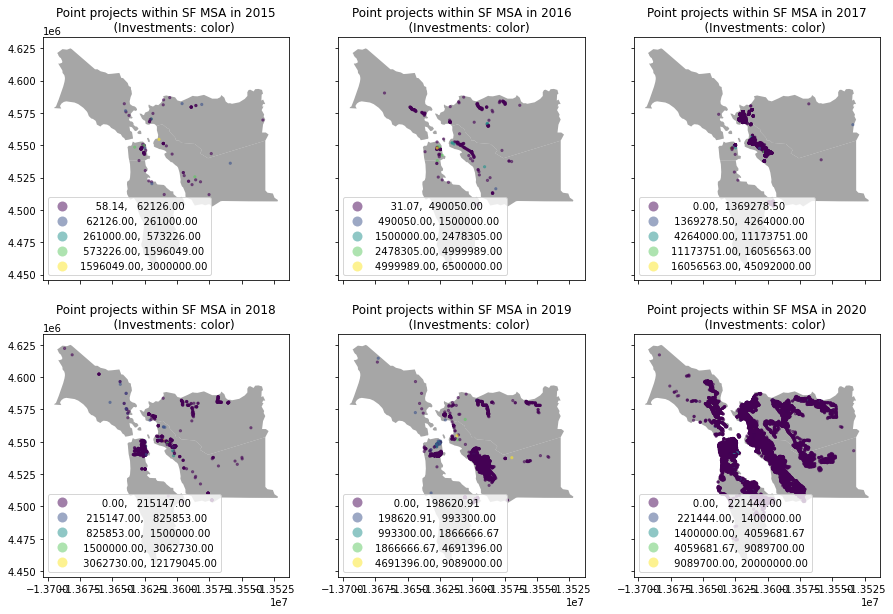

In [91]:
f,axs = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_point[sf_point.reportingcyclename==y].plot(ax=ax,column='Funding',markersize=5,legend=True,scheme='natural_breaks',alpha=0.5)
    ax.set_title(f'''Point projects within SF MSA in {y}
    (Investments: color)''')
plt.show()

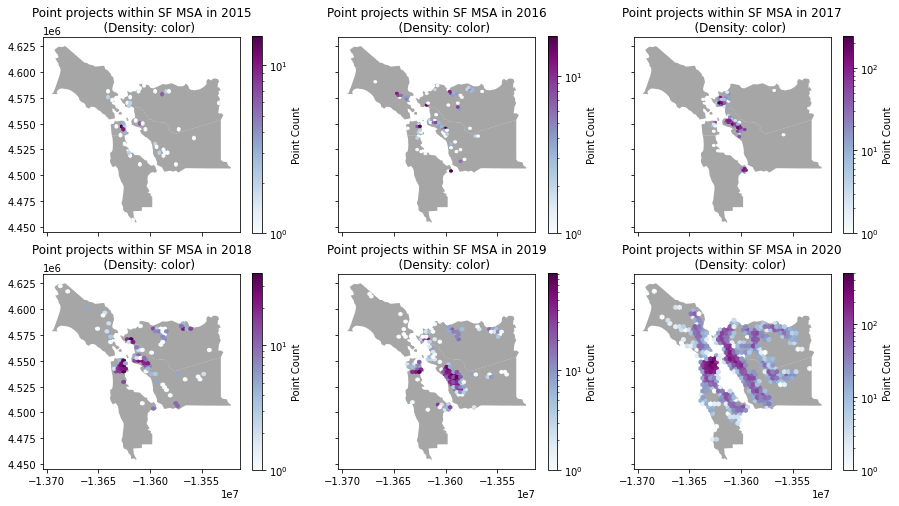

In [96]:
f,axs = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    data = sf_point[sf_point.reportingcyclename==y]
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    hb = ax.hexbin(data.geometry.x,data.geometry.y, gridsize=40, cmap='BuPu',mincnt=1,bins='log')
    ax.set_title(f'''Point projects within SF MSA in {y}
    (Density: color)''')
    plt.colorbar(hb,label='Point Count',ax=ax)
plt.show()


In [63]:
#sf_point.to_csv('data/01finished/sf_point.csv') 
sf_point.to_file('data/sf_project/sf_point.geojson', driver='GeoJSON')

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Deal with Repeated Projects

In [722]:
cci[cci.ProjectIDNumber=='G14-AQIP-01'].head()

,ProjectIDNumber,ReportingCycleName,AgencyName,ProgramName,ProgramDescription,SubProgramName,RecordType,ProjectName,ProjectType,ProjectDescription,CensusTract,Address,LatLong,TotalProjectCost,TotalProgramGGRFFunding,ProjectLifeYears,TotalProjectGHGReductions,AnnualProjectGHGReductions,ProjectCount,FiscalYearFundingProject,IsBenefitDisadvantagedCommunities,DisadvantagedCommunityCriteria,DisadvantagedCommunityNeed,DisadvantagedCommunityCensusTracts,TotalGGRFDisadvantagedCommunityFunding,DisadvantagedCommunityBenefitsDescription,FundingBenefitingDisadvantagedCommunities,EstimatedNumVehiclesInService,FundingWithinDisadvantageCommunities,OtherProjectBenefitsDescription,VMTReductions,NumberOfHousingUnits,NumberOfAffordableHousingUnits,EstimatedNumberOfTreesToBePlanted,ENERGY_Cost_Savings,EstimatedEnergySavedKWH,EstimatedEnergySavedTherms,EstimatedWaterSavedGallons,EstimatedEnergyGeneratedKWH,EstimatedFuelUseReductionGal,VouchersBenefitingDisadvantagedCommunities,NumberOfRebatesIssued,RebatesWithinDisadvantagedCommunities,DateOperational,ProjectCompletionDate,DateImported,FundingRecipient,AB1550Choice,BufferAmount,BufferCount,IsAB1550BufferRegion,CESVersion,DAC3Amount,DAC3Count,IsBenefitDAC3Communities,DateSelectedForAward,LowIncomeAmount,LowIncomeCount,LowIncomeHouseholdAmount,LowIncomeHouseholdCount,IsLowIncomeCommunities,PotentialBufferAmount,PotentialBufferCount,PotentialDAC3Amount,PotentialDAC3Count,PotentialLowIncomeAmount,PotentialLowIncomeCount,EstimatedAcresPreserved,EstimatedAcresRestored,EstimatedAcresTreated,EstimatedDivertedFromLandfillsTons,RenewableFuelGenerationTons,WoodBurningReductionCords,EstimatedRidershipIncreases,BlackCarbonReductionsTons,StateEW_DPM,StateEW_Nox,StateEW_PM25,StateEW_ROG,DieselPmReductionsLbs,NOxReductionsLbs,Pm25ReductionsLbs,RogReductionsTLbs,EstimatedTotalRecyclingTons,EstimatedWasteDigestedTons,ReclaimedFoodTons,NUMBER_OF_PLANS,POLLINATOR_ACREAGE,RESEARCH_GRANT,SCIENCE_ADVANCEMENT,SOIL_BENEFIT,TRAVEL_COST_SAVINGS,EST_ENERGY_GEN_SCF,EST_SOURCE_RED_TONS,FUEL_TREATMENT_NUM,EDUCATION_EVENT_NUM,ENERGY_AUDIT_BUILDINGS,EST_DIVERT_LANDFILLS_TONS,EST_FUEL_GEN_GAL,VoucherID,VoucherName,VoucherDescription,DirectJobsFte,IndirectJobsFte,InducedJobsFte,ClimateAdaptation,CommunityEngagement,CompostProducedTons,CompostProducedTonsYr,NetDensityDUA,ApplicantsAssisted,InvasiveCover12Mon,InvasiveCover36Mon,ProjectAcreage,IntermediaryAdminExpenses
5776,G14-AQIP-01,2015,Air Resources Board,Low Carbon Transportation,Provides mobile source incentives to reduce GH...,Clean Vehicle Rebate Project,IMPLEMENT,NaN,NaN,Provide rebate incentives for consumers to pur...,6.001440e+09,NaN,NaN,420000,20758,15,485,0,10,NaN,True,1-2A,Common Need,6001437101.0,20758,Common Need,20758,0,0,NaN,0.0,0,0,0,0,0,0,0,0,0,10,10,0,NaN,5/1/17,4/22/21 14:17,Center for Sustainable Energy (CSE),NaN,0,0,False,2.0,0,0,False,NaN,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0,0,0,0,0,0,0,False
5777,G14-AQIP-01,2015,Air Resources Board,Low Carbon Transportation,Provides mobile source incentives to reduce GH...,Clean Vehicle Rebate Project,IMPLEMENT,NaN,NaN,Provide rebate incentives for consumers to pur...,6.037199e+09,NaN,NaN,42000,2595,15,50,0,1,NaN,True,1-1A,Common Need,6037199110.0,2595,Common Need,2595,0,2595,NaN,0.0,0,0,0,0,0,0,0,0,0,1,1,1,NaN,5/1/17,4/22/21 14:17,Center for Sustainable Energy (CSE),NaN,0,0,False,2.0,0,0,False,NaN,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0,0,0,0,0,0,0,False
5778,G14-AQIP-01,2015,Air Resources Board,Low Carbon Transportation,Provides mobile source incentives to reduce GH...,Clean Vehicle Rebate Project,IMPLEMENT,NaN,NaN,Provide rebate incentives for consumers to pur...,6.085500e+09,NaN,NaN,546000,28957,15,644,0,13,NaN,True,1-2A,Common Need,6085505100.0,28957,Common Need,28957,0,0,NaN,0.0,0,0,0,0,0,0,0,0,0,13,13,0,NaN,5/1/17,4/22/21 14:17,

## Data Processing - Census Block Groups

In [107]:
sf_bg = ca_bg.clip(sf_boundary)
sf_bg = sf_bg[(sf_bg.geometry.type != 'LineString')&(sf_bg.geometry.type != 'GeometryCollection')&(sf_bg.geometry.type != 'Point')]

In [142]:
sf_bg['area'] = sf_bg.geometry.area #get the area info for each cbg

In [143]:
ca_popu['geoid'] = ca_popu['id'].str.slice(-12,)

In [ ]:
ca_popu_merge = ca_popu[['geoid','Estimate!!Total']]
ca_popu_merge.columns = ['geoid','TotalPopu'] #change the names of columns

In [145]:
sf_bg_popu = sf_bg.merge(ca_popu_merge,how='left',left_on='GEOID',right_on='geoid')

In [146]:
sf_bg_popu.to_file('data/sf_bg/sf_bg.geojson', driver='GeoJSON')

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
